In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch # Deep learning framework
import torch.nn.functional as F
import time

# Input data files are available in the "../input/" directory.
import os
print(os.listdir("../input/wili3"))

#Init random seed to get reproducible results
seed = 1111
random.seed(seed)
np.random.RandomState(seed)
torch.manual_seed(seed)

# Any results you write to the current directory are saved as output.
x_train_full = open("../input/wili3/x_train.txt").read().splitlines()
y_train_full = open("../input/wili3/y_train.txt").read().splitlines()
print('Example:')
print('LANG =', y_train_full[0])
print('TEXT =', x_train_full[0])

['Scripts.txt', 'x_test.txt', 'y_train.txt', 'labels.csv', 'x_train.txt']
Example:
LANG = est
TEXT = Klement Gottwaldi surnukeha palsameeriti ning paigutati mausoleumi. Surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemärke. 1962. aastal viidi ta surnukeha mausoleumist ära ja kremeeriti. Zlíni linn kandis aastatel 1949–1989 nime Gottwaldov. Ukrainas Harkivi oblastis kandis Zmiivi linn aastatel 1976–1990 nime Gotvald.


In [2]:
class Dictionary(object):
    def __init__(self):
        self.token2idx = {}
        self.idx2token = []

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def __len__(self):
        return len(self.idx2token)

The **Dictionary** class is used to map tokens (characters, words, subwords) into consecutive integer indexes.  
The index **0** is reserved for padding sequences up to a fixed lenght, and the index **1** for any 'unknown' character

In [3]:
#char_vocab = Dictionary()
pair_vocab = Dictionary()
pad_token = '<pad>' # reserve index 0 for padding
unk_token = '<unk>' # reserve index 1 for unknown token
#pad_index = char_vocab.add_token(pad_token)
#unk_index = char_vocab.add_token(unk_token)
pad_index = pair_vocab.add_token(pad_token)
unk_index = pair_vocab.add_token(unk_token)

# join all the training sentences in a single string
# and obtain the list of different characters with set

chars = list(''.join(x_train_full))
#chars = set(''.join(x_train_full))
#for char in sorted(chars):
#    char_vocab.add_token(char)
#print("Vocabulary:", len(char_vocab), "UTF characters")
i=0
k=0
for char in chars:
    if k==0:
        c1 = char
        #print(c1)
        k=1
        if i>0:
            pair_vocab.add_token(c2+c1)
    else:
        c2=char
        #print(c2)
        pair_vocab.add_token(c1+c2)
        k=0
    i=i+1
    #input()
    
print("Vocabulary:", len(pair_vocab), "UTF pairs")


lang_vocab = Dictionary()
# use python set to obtain the list of languages without repetitions
languages = set(y_train_full)
for lang in sorted(languages):
    lang_vocab.add_token(lang)
print("Labels:", len(lang_vocab), "languages")

Vocabulary: 317440 UTF pairs
Labels: 235 languages


In [4]:
#From token or label to index
print('a ->', pair_vocab.token2idx['An'])
#print('a ->', char_vocab.token2idx['a'])
print('cat ->', lang_vocab.token2idx['cat'])
print(y_train_full[0], x_train_full[0][:10])
x_train_idx = []
t = 0
for line in x_train_full:
    t=t+1
    i = 0
    k = 0
    tmp = []
    for c in line:
        if k==0:
            c1 = c
            k=1
            if i>0:
                tmp.append(pair_vocab.token2idx[c2+c1])
            i=i+1
        else:
            c2 = c
            tmp.append(pair_vocab.token2idx[c1+c2])
            k=0
    x_train_idx.append(np.array(tmp))

#x_train_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in x_train_full]
y_train_idx = np.array([lang_vocab.token2idx[lang] for lang in y_train_full])
#print(y_train_idx[0], x_train_idx[0][:10])

a -> 911
cat -> 28
est Klement Go


Radomly select 15% of the database for validation  
Create lists of (input, target) tuples for training and validation

In [5]:
if '地路' in pair_vocab.token2idx:
    print('hola')
else:
    print('hey')

hey


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_idx, y_train_idx, test_size=0.15, random_state=seed)
train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
print(len(train_data), "training samples")
print(len(val_data), "validation samples")

99875 training samples
17625 validation samples


In [7]:
def batch_generator(data, batch_size, token_size):
    """Yield elements from data in chunks with a maximum of batch_size sequences and token_size tokens."""
    minibatch, sequences_so_far, tokens_so_far = [], 0, 0
    for ex in data:
        minibatch.append(ex)
        seq_len = len(ex[0])
        if seq_len > token_size:
            ex = (ex[0][:token_size], ex[1])
            seq_len = token_size
        sequences_so_far += 1
        tokens_so_far += seq_len
        if sequences_so_far == batch_size or tokens_so_far == token_size:
            yield minibatch
            minibatch, sequences_so_far, tokens_so_far = [], 0, 0
        elif sequences_so_far > batch_size or tokens_so_far > token_size:
            yield minibatch[:-1]
            minibatch, sequences_so_far, tokens_so_far = minibatch[-1:], 1, len(minibatch[-1][0])
    if minibatch:
        yield minibatch

In [8]:
def pool_generator(data, batch_size, token_size, shuffle=False):
    """Sort within buckets, then batch, then shuffle batches.
    Partitions data into chunks of size 100*token_size, sorts examples within
    each chunk, then batch these examples and shuffle the batches.
    """
    for p in batch_generator(data, batch_size * 100, token_size * 100):
        p_batch = batch_generator(sorted(p, key=lambda t: len(t[0]), reverse=True), batch_size, token_size)
        p_list = list(p_batch)
        if shuffle:
            for b in random.sample(p_list, len(p_list)):
                yield b
        else:
            for b in p_list:
                yield b

**DNN Model**  
Includes Python comments with the dimension of the input  matrix:  
T = Max number of tokens in a sequence  
B = Number of sequences (batch size)  
E = Embedding dim  
H = Hidden size  
O = Output size (number of languages)

In [9]:
class CharRNNClassifier(torch.nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, output_size, model="lstm", num_layers=1, bidirectional=False, pad_idx=0):
        super().__init__()
        self.model = model.lower()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(input_size, embedding_size, padding_idx=pad_idx)
        if self.model == "gru":
            self.rnn = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        elif self.model == "lstm":
            self.rnn = torch.nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        self.drop =  torch.nn.Dropout(p=0.5)
        
    def forward(self, input, input_lengths):
        # T x B
        encoded = self.embed(input)
        # T x B x E
        packed = torch.nn.utils.rnn.pack_padded_sequence(encoded, input_lengths)
        # Packed T x B x E
        output, _ = self.rnn(packed)
        # Packed T x B x H
        # Important: you may need to replace '-inf' with the default zero padding for other pooling layers
        padded_m, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=float('-inf'))
        # T x B x H
        output_m, _ = padded_m.max(dim=0)
        
        padded_a, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=0)
        output_a = padded_a.mean(dim=0)
        
        output = (output_m + output_a)
        # B x H
        output = self.drop(self.h2o(output))
        # B x O
        return output

In [10]:
if not torch.cuda.is_available():
    print("WARNING: CUDA is not available. Select 'GPU On' on kernel settings")
device = torch.device("cuda")
torch.cuda.manual_seed(seed)

The **nn.CrossEntropyLoss()** criterion combines **nn.LogSoftmax()** and **nn.NLLLoss()** in one single class.  
It is useful when training a classification problem.

In [11]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [12]:
def train(model, optimizer, data, batch_size, token_size, log=False):
    model.train()
    total_loss = 0
    ncorrect = 0
    nsentences = 0
    ntokens = 0
    niterations = 0
    for batch in pool_generator(data, batch_size, token_size, shuffle=True):
        # Get input and target sequences from batch
        X = [torch.from_numpy(d[0]) for d in batch]
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long, device=device)
        y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
        # Pad the input sequences to create a matrix
        X = torch.nn.utils.rnn.pad_sequence(X).to(device)
        model.zero_grad()
        output = model(X, X_lengths)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        # Training statistics
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        nsentences += y.numel()
        niterations += 1
    
    total_loss = total_loss / nsentences
    accuracy = 100 * ncorrect / nsentences
    if log:
        print(f'Train: wpb={ntokens//niterations}, bsz={nsentences//niterations}, num_updates={niterations}')
    return accuracy

In [13]:
def validate(model, data, batch_size, token_size):
    model.eval()
    # calculate accuracy on validation set
    ncorrect = 0
    nsentences = 0
    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            # Get input and target sequences from batch
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long, device=device)
            y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            ncorrect += (torch.max(answer, 1)[1] == y).sum().item()
            nsentences += y.numel()
        dev_acc = 100 * ncorrect / nsentences
    return dev_acc

In [14]:
hidden_size = 512
embedding_size = 64
bidirectional = False
#ntokens = len(char_vocab)
ntokens = len(pair_vocab)
nlabels = len(lang_vocab)

Model for cross-validation

In [15]:
def get_model():
    model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, model = 'gru', bidirectional=bidirectional, pad_idx=pad_index).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    return model, optimizer

In [16]:
batch_size, token_size = 256, 200000
epochs = 25
train_accuracy = []
valid_accuracy = []
model, optimizer = get_model()
print(f'Training cross-validation model for {epochs} epochs')
t0 = time.time()
for epoch in range(1, epochs + 1):
    acc = train(model, optimizer, train_data, batch_size, token_size, log=epoch==1)
    train_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | train accuracy={acc:.1f}% ({time.time() - t0:.0f}s)')
    acc = validate(model, val_data, batch_size, token_size)
    valid_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | valid accuracy={acc:.1f}%')

Training cross-validation model for 25 epochs
Train: wpb=90289, bsz=245, num_updates=407
| epoch 001 | train accuracy=28.9% (103s)
| epoch 001 | valid accuracy=82.7%
| epoch 002 | train accuracy=45.9% (210s)
| epoch 002 | valid accuracy=89.8%
| epoch 003 | train accuracy=47.4% (316s)
| epoch 003 | valid accuracy=91.9%
| epoch 004 | train accuracy=47.6% (423s)
| epoch 004 | valid accuracy=92.2%
| epoch 005 | train accuracy=48.4% (530s)
| epoch 005 | valid accuracy=92.8%
| epoch 006 | train accuracy=49.0% (637s)
| epoch 006 | valid accuracy=93.4%
| epoch 007 | train accuracy=49.3% (744s)
| epoch 007 | valid accuracy=93.3%
| epoch 008 | train accuracy=49.0% (852s)
| epoch 008 | valid accuracy=93.4%
| epoch 009 | train accuracy=49.5% (960s)
| epoch 009 | valid accuracy=93.7%
| epoch 010 | train accuracy=49.6% (1068s)
| epoch 010 | valid accuracy=93.6%
| epoch 011 | train accuracy=49.9% (1176s)
| epoch 011 | valid accuracy=93.8%
| epoch 012 | train accuracy=49.7% (1284s)
| epoch 012 | valid

In [17]:
print(model)
for name, param in model.named_parameters():
    print(f'{name:20} {param.numel()} {list(param.shape)}')
print(f'TOTAL                {sum(p.numel() for p in model.parameters())}')

CharRNNClassifier(
  (embed): Embedding(317440, 64, padding_idx=0)
  (rnn): GRU(64, 512)
  (h2o): Linear(in_features=512, out_features=235, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)
embed.weight         20316160 [317440, 64]
rnn.weight_ih_l0     98304 [1536, 64]
rnn.weight_hh_l0     786432 [1536, 512]
rnn.bias_ih_l0       1536 [1536]
rnn.bias_hh_l0       1536 [1536]
h2o.weight           120320 [235, 512]
h2o.bias             235 [235]
TOTAL                21324523


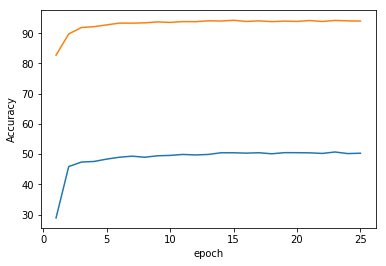

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(train_accuracy)+1), train_accuracy)
plt.plot(range(1, len(valid_accuracy)+1), valid_accuracy)
plt.xlabel('epoch')
plt.ylabel('Accuracy');

**Final model**  
Finally, we create a model using all the training data and we generate the submission with the predicted test labels

In [19]:
print(f'Training final model for {epochs} epochs')
model, optimizer = get_model()
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Model Parameters: '+ str(count_parameters(model)))
t0 = time.time()
for epoch in range(1, epochs + 1):
    acc = train(model, optimizer, train_data + val_data, batch_size, token_size, log=epoch==1)
    print(f'| epoch {epoch:03d} | train accuracy={acc:.3f} ({time.time() - t0:.0f}s)')

Training final model for 25 epochs
Model Parameters: 21324523
Train: wpb=90260, bsz=245, num_updates=479
| epoch 001 | train accuracy=31.661 (124s)
| epoch 002 | train accuracy=46.337 (248s)
| epoch 003 | train accuracy=47.466 (372s)
| epoch 004 | train accuracy=48.041 (496s)
| epoch 005 | train accuracy=48.545 (619s)
| epoch 006 | train accuracy=49.081 (743s)
| epoch 007 | train accuracy=49.148 (867s)
| epoch 008 | train accuracy=49.218 (991s)
| epoch 009 | train accuracy=49.786 (1115s)
| epoch 010 | train accuracy=49.888 (1239s)
| epoch 011 | train accuracy=50.177 (1363s)
| epoch 012 | train accuracy=50.380 (1486s)
| epoch 013 | train accuracy=50.196 (1610s)
| epoch 014 | train accuracy=50.134 (1734s)
| epoch 015 | train accuracy=50.532 (1858s)
| epoch 016 | train accuracy=50.406 (1982s)
| epoch 017 | train accuracy=50.240 (2106s)
| epoch 018 | train accuracy=50.283 (2229s)
| epoch 019 | train accuracy=50.354 (2352s)
| epoch 020 | train accuracy=50.309 (2476s)
| epoch 021 | train acc

In [20]:
def test(model, data, batch_size, token_size):
    model.eval()
    sindex = []
    labels = []
    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            # Get input sequences from batch
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long, device=device)
            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            label = torch.max(answer, 1)[1].cpu().numpy()
            # Save labels and sentences index
            labels.append(label)
            sindex += [d[1] for d in batch]
    return np.array(sindex), np.concatenate(labels)

In the test database we replace the label (language) with a sentence index.  

In [21]:
print(c2+c1)
tmp.append(pair_vocab.token2idx[c1+c2])

l.


In [22]:
x_test_txt = open("../input/wili3/x_test.txt").read().splitlines()
#x_test_idx = [np.array([char_vocab.token2idx[c] if c in char_vocab.token2idx else unk_index for c in line]) for line in x_test_txt]
x_test_idx = []


t = 0
for line in x_test_txt:
    t=t+1
    i = 0
    k = 0
    tmp = []
    for c in line:
        if k==0:
            c1 = c
            k=1
            if i>0:
                if c2+c1 in pair_vocab.token2idx:
                    tmp.append(pair_vocab.token2idx[c2+c1])
                else:
                    tmp.append(pair_vocab.add_token(unk_token))
            i=i+1
        else:
            c2 = c
            if c1+c2 in pair_vocab.token2idx:
                tmp.append(pair_vocab.token2idx[c1+c2])
            else:
                tmp.append(pair_vocab.add_token(unk_token))
            k=0
    x_test_idx.append(np.array(tmp))
test_data = [(x, idx) for idx, x in enumerate(x_test_idx)]

The sentence index is used to rearrange the labels in the original sentence order

In [23]:
index, labels = test(model, test_data, batch_size, token_size)
order = np.argsort(index)
labels = labels[order]

In [24]:
with open('submission.csv', 'w') as f:
    print('Id,Language', file=f)
    for sentence_id, lang_id in enumerate(labels):
        language = lang_vocab.idx2token[lang_id]
        if sentence_id < 10:
            print(f'{sentence_id},{language}')
        print(f'{sentence_id},{language}', file=f)

0,mwl
1,nds-nl
2,ava
3,tcy
4,bjn
5,mon
6,snd
7,lez
8,bul
9,nan
